# PIK3CA Methods - Analyzing the cis effects of PIK3CA mutation on p110

## Standard Imports

### Python packages used for analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re 

<b> Import CPTAC data </b>

In [2]:
import CPTAC.Endometrial as CPTAC

Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


# 1. Set up initial dataframes and variables 

In [3]:
gene = 'PIK3CA'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

hotspot_patients_both_keys = mutated_hotspot[['Clinical_Patient_Key', 'Patient_Id']]
hotspot_patients = hotspot_patients_both_keys['Clinical_Patient_Key']
print(hotspot_patients)

#The pvalue cutoff used to find significance
pcutoff = 0.05


160      S001
1147     S003
1426     S009
4757     S021
16613    S023
19188    S024
21386    S032
21643    S033
22656    S038
37618    S061
38352    S063
39719    S066
43588    S067
43687    S068
46859    S084
47557    S088
48398    S090
49903    S097
50016    S098
Name: Clinical_Patient_Key, dtype: object


# 2. Find number of patients with PIK3CA mutations in/outside the hotspot

In [4]:
print("Mutations inside hotspot: " + str(len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']
#note: the gene PIK3CA encodes for the protein p110α, hence the variable 'p110_mutated'

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p110_mutated['Clinical_Patient_Key'])) - 1
print("Total number of patients with mutations: " + str(num_mutated))

Mutations inside hotspot: 19
Total number of patients with mutations: 48


# 3. PIK3CA cis effects

# 3a. Proteomics analysis

In [5]:
protein = 'PIK3CA'
# 1. Merge the mutation status of PIK3CA and the protemics data of PIK3CA
p110_mutations_protein = CPTAC.compare_mutations(proteomics, protein)
#note - CPTAC will return a dataframe of the mutation status and proteomics of the same gene 
#   if only two parameters are provided: the dataframe and the mutation/protein being analyzed

# 2. Set up a new column for mutations that are within the hotspot
p110_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p110_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p110_mutations_protein.loc[p110_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'

# 3. Select for tumor samples only 
p110_mutations_protein = p110_mutations_protein.loc[p110_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)

# 4. Make three new dataframes, one for people with a hotspot mutation, one for those with mutations outside the hotspot, and  one for all the wildtype cancer patients
hotspot_mut = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Within Hotspot'] 
non_hotspot_mut = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']
wt = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Wildtype']


# 5. ttest for proteomics of PIK3CA between wildtype cancer and hotspot mutation
ttest = scipy.stats.ttest_ind(hotspot_mut[protein], wt[protein])
print(protein + ' proteomics hotspot mutations vs wildtype: ' + str(ttest[1]))

#Perform a ttest for non-hotspot mutations vs wildtype 
ttest = scipy.stats.ttest_ind(non_hotspot_mut[protein], wt[protein])
print('Non-hotspot mutations vs wildtype: ' + str(ttest[1]))

# 6. Repeat for all mutations vs wildtype cancer
all_mutated = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] != 'Wildtype']
ttest = scipy.stats.ttest_ind(all_mutated[protein], wt[protein])
print(protein + " proteomics all mutation vs wildtype: " + str(ttest[1]))

PIK3CA proteomics hotspot mutations vs wildtype: 0.008593903345120646
Non-hotspot mutations vs wildtype: 0.12070043343430814
PIK3CA proteomics all mutation vs wildtype: 0.012010830576504043


# 3b. Plot the data 

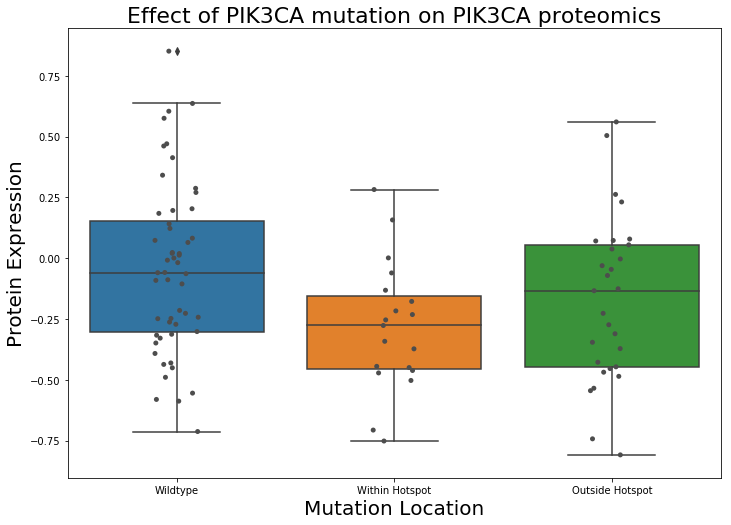

In [6]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p110_mutations_protein, x = 'Within_Hotspot', order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], y = protein, ax = ax)
boxplt = sns.stripplot(data = p110_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
plt.show()

### We can conclude from these results that there are no significant changes in PIK3CA protein abundance when mutated, within or outside of the hotspot. 

# 4a. Phosphoproteomic analysis

In [7]:
protein = 'PIK3CA-'
pattern = re.compile(protein)

# 1. Create a dataframe combining phosphosite data with PIK3CA mutation status; select for tumor samples
p110_mutations_phos = CPTAC.compare_mutations(phos, protein, gene)
p110_mutations_phos = p110_mutations_phos.loc[p110_mutations_phos['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)

# 2. Make a new column for mutation location reative to hotspot 
p110_mutations_phos['Within_Hotspot'] = 'Outside Hotspot'
p110_mutations_phos.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p110_mutations_phos.loc[p110_mutations_phos['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p110_mutations_phos.drop('Mutation', axis = 1)

# 3. Begin constructing a dataframe for plotting, starting only with the mutation location 
plotdf = p110_mutations_phos[['Within_Hotspot']]

# 4. Loop through each phosphosite to check for significance:

for site in p110_mutations_phos.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p110_mutations_phos[[site, 'Within_Hotspot']].dropna(axis=0)
        hotspot_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Within Hotspot']
        non_hotspot_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Outside Hotspot']
        wt_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
        all_phos_mut = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype']
        
        #Perform a ttest for hotspot vs wildtype 
        ttest = scipy.stats.ttest_ind(hotspot_phos[site], wt_phos[site])
        print('PIK3CA hotspot mutation and ' , site , ": " +  str(ttest[1]))
        plotdf = plotdf.join(p110_mutations_phos[site])
        
        #Perform a ttest for all mutations vs wildtype
        ttest = scipy.stats.ttest_ind(all_phos_mut[site], wt_phos[site])
        print('All PIK3CA mutation and ',  site + ": " + str(ttest[1]))
        
        #Perform a ttest for non-hotspot mutations vs wildtype
        ttest = scipy.stats.ttest_ind(non_hotspot_phos[site], wt_phos[site])
        print('Non-hotspot PIK3CA mutation and ',  site , ": " + str(ttest[1]))

PIK3CA hotspot mutation and  PIK3CA-S312 : 0.18163409773877998
All PIK3CA mutation and  PIK3CA-S312: 0.1043693260824297
Non-hotspot PIK3CA mutation and  PIK3CA-S312 : 0.19506694474065406
PIK3CA hotspot mutation and  PIK3CA-T313 : 0.05040438070591449
All PIK3CA mutation and  PIK3CA-T313: 0.10779226839236934
Non-hotspot PIK3CA mutation and  PIK3CA-T313 : 0.3531345354301664


# 4b. Plot the data

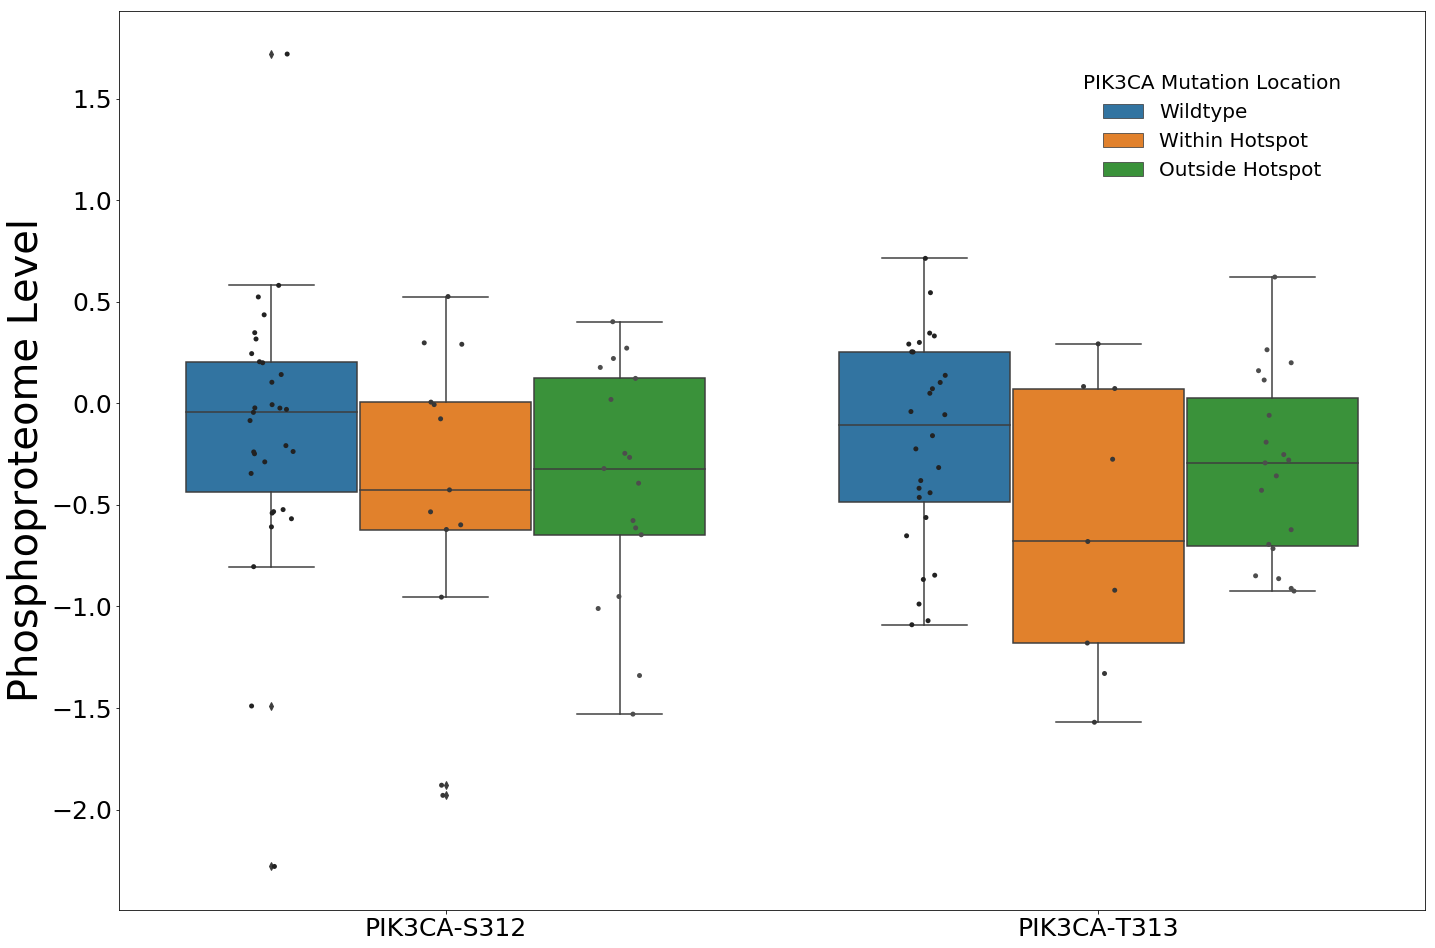

In [8]:
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)

a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue = 'Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphoproteome Level', fontsize='40')
boxplt.tick_params(labelsize='25')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype', 'Within Hotspot', 'Outside Hotspot'], title='PIK3CA Mutation Location', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.95, 0.95, 0, 0))

### We can conclude that PIK3CA mutation, within or outside of the hotspot, does not affect its phosphorylation levels 